In [1]:
from cell_env import CellEnv
# Use sb3 env checker:
from stable_baselines3.common.env_checker import check_env
from stable_baselines3 import PPO, DQN

In [2]:
env = CellEnv()
check_env(env)
env.reset()
env.step(0)
env.step(1)
env.close()

In [3]:
from stable_baselines3.common.vec_env import DummyVecEnv
from gymnasium.wrappers import TimeLimit
from stable_baselines3.common.monitor import Monitor


# eval wrapper:
env = TimeLimit(env, 1000)
# use the monitor wrapper to log the results:
env = Monitor(env)
from stable_baselines3.common.callbacks import EvalCallback
eval_env = TimeLimit(CellEnv(), 1000)
eval_env = Monitor(eval_env)

In [4]:

eval_callback = EvalCallback(eval_env, best_model_save_path='./rl-models/',
                             log_path='./rl-logs/', eval_freq=1000,
                             deterministic=True, render=False,
                             )
# model = PPO("MlpPolicy", env, verbose=4,
#             tensorboard_log="./rl-logs/")
model = DQN("MlpPolicy", DummyVecEnv([lambda: Monitor(env)]), verbose=4, tensorboard_log="./rl-logs/",
            exploration_fraction=0.4,
            target_update_interval=5000,
            buffer_size=100000,
            learning_starts=1000,
            learning_rate=0.001
)
model.learn(total_timesteps=1000000, tb_log_name="ppo",
            callback=eval_callback)


Using cpu device
Logging to ./rl-logs/ppo_11
Eval num_timesteps=1000, episode_reward=-381.62 +/- 0.00
Episode length: 1000.00 +/- 0.00
----------------------------------
| eval/               |          |
|    mean_ep_length   | 1e+03    |
|    mean_reward      | -382     |
| rollout/            |          |
|    exploration_rate | 0.996    |
| time/               |          |
|    total_timesteps  | 1000     |
----------------------------------
New best mean reward!
Eval num_timesteps=2000, episode_reward=-381.62 +/- 0.00
Episode length: 1000.00 +/- 0.00
----------------------------------
| eval/               |          |
|    mean_ep_length   | 1e+03    |
|    mean_reward      | -382     |
| rollout/            |          |
|    exploration_rate | 0.992    |
| time/               |          |
|    total_timesteps  | 2000     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00486  |
|    n_updates        | 249      |
------------------

In [47]:
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(env_class, max_steps, num_episodes, model=None):
    """
    Evaluate the model over several episodes and plot the results.

    Parameters:
    - model: Trained RL model to be evaluated.
    - env_class: Environment class to create new instances of the evaluation environment.
    - max_steps: Maximum number of steps per episode.
    - num_episodes: Number of episodes to evaluate.

    Returns:
    - avg_observations: Average observations at each step.
    - all_observations: List of observations for all episodes.
    """
    all_observations = []

    for _ in range(num_episodes):
        eval_env = TimeLimit(env_class(), max_steps)
        done = False
        obs, _ = eval_env.reset()
        episode_observations = []
        while not done:
            if model is not None:
                action, _states = model.predict(obs)
            else:
                action = eval_env.action_space.sample()
            obs, rewards, term, trunc, info = eval_env.step(action)
            done = term or trunc
            episode_observations.append(info['n_cells'])
        
        all_observations.append(episode_observations)
    
    # Compute the average observations
    max_len = max(len(obs) for obs in all_observations)
    avg_observations = np.zeros(max_len)
    counts = np.zeros(max_len)
    
    for obs in all_observations:
        for i, val in enumerate(obs):
            avg_observations[i] += val[-1]
            counts[i] += 1
    
    avg_observations /= counts

    return avg_observations, all_observations




def plot_observations(avg_observations, all_observations, unif_obs=None, all_unif_obs=None):
    """
    Plot the average observations and individual episode tracks.

    Parameters:
    - avg_observations: Average observations at each step.
    - all_observations: List of observations for all episodes.
    """
    plt.figure(figsize=(12, 8))
    
    # Plot individual episode tracks with lower alpha
    for obs in all_observations:
        plt.plot(x_axis, obs, alpha=0.05, linewidth=0.5, color='black')

    if unif_obs is not None:
        for obs in all_unif_obs:
            plt.plot(x_axis, obs, alpha=0.05, linewidth=0.5, color='red')
    
    # Plot average observations
    plt.plot(x_axis, avg_observations, label='trained policy', linewidth=3, color='black')
    if unif_obs is not None:
        plt.plot(x_axis, unif_obs, label='random policy', linewidth=3, color='red')
    
    plt.xlabel('Time (hours)')
    plt.ylabel('Total cells (n_cells)')
    plt.title('Model Evaluation: Average Observations and Individual Episode Tracks')
    plt.legend()
    plt.yscale('log')
    plt.show()


In [52]:
# Example usage:
avg_obs, all_obs = evaluate_model(CellEnv, 1200, 10, model)
unif_obs, unif_all_obs = evaluate_model(CellEnv, 1200, 10)

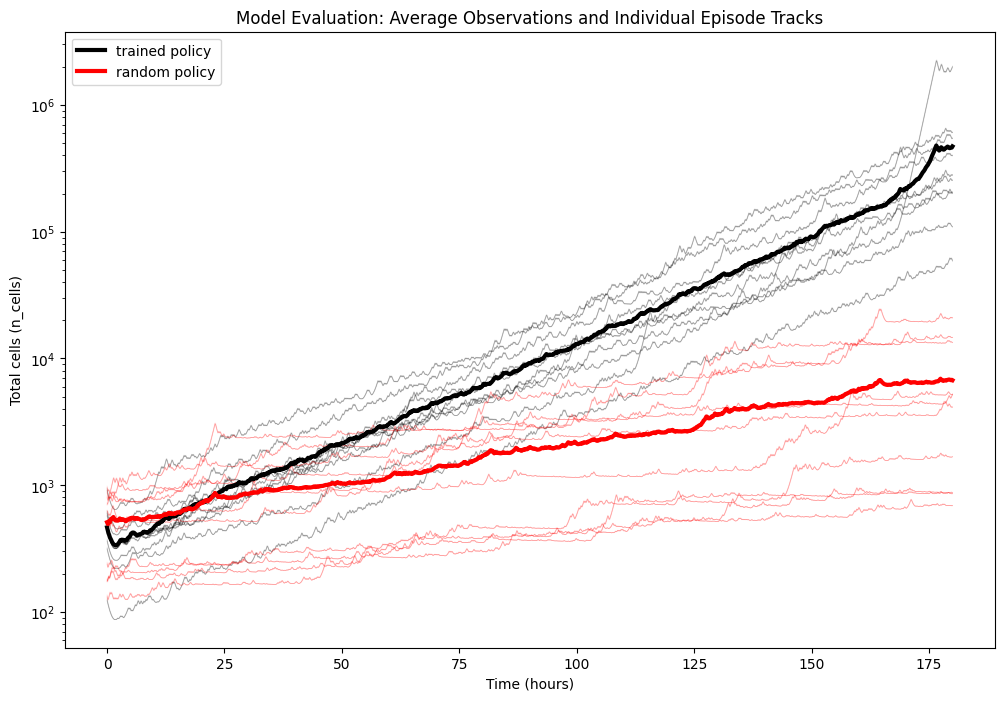

In [53]:
plot_observations(avg_obs, all_obs, unif_obs, unif_all_obs)